In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob 
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [40]:
corn_Common_Rust_images = glob("dataset/Corn/Corn___Common_Rust/*.jpg")
corn_Gray_Leaf_Spot_images = glob("dataset/Corn/Corn___Gray_Leaf_Spot/*.jpg")
corn_Healthy_images = glob("dataset/Corn/Corn___Healthy/*.jpg")
corn_Northern_Leaf_Blight_images = glob("dataset/Corn/Corn___Northern_Leaf_Blight/*.jpg")

In [41]:
print(f"Number of corn_Common_Rust_images: {len(corn_Common_Rust_images)}")
print(f"Number of corn_Gray_Leaf_Spot_images: {len(corn_Gray_Leaf_Spot_images)}")
print(f"Number of corn_Healthy_images: {len(corn_Healthy_images)}")
print(f"Number of corn_Northern_Leaf_Blight_images: {len(corn_Northern_Leaf_Blight_images)}")

Number of corn_Common_Rust_images: 1192
Number of corn_Gray_Leaf_Spot_images: 513
Number of corn_Healthy_images: 1162
Number of corn_Northern_Leaf_Blight_images: 985


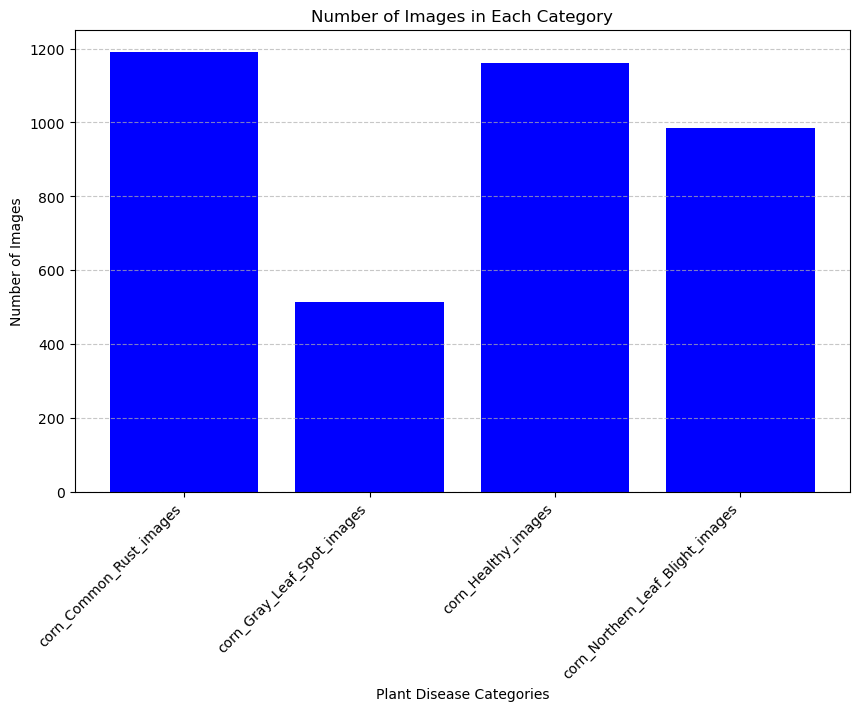

In [56]:
labels = ["corn_Common_Rust_images","corn_Gray_Leaf_Spot_images","corn_Healthy_images","corn_Northern_Leaf_Blight_images"]
counts = [len(corn_Common_Rust_images),len(corn_Gray_Leaf_Spot_images),len(corn_Healthy_images),len(corn_Northern_Leaf_Blight_images)]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

# Add labels and title
plt.xlabel("Plant Disease Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Category")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [43]:


IMG_SIZE = (128, 128)

def load_images(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sorted for consistency
    label_map = {name: idx for idx, name in enumerate(class_names)}  # Label encoding

    for label in class_names:
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for file in glob(os.path.join(class_folder, "*.jpg")):  # Load only images
                img = cv2.imread(file)
                if img is None:
                    continue  # Skip unreadable images

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize image
                img = img / 255.0  # Normalize pixels (0-1)
                
                images.append(img)
                labels.append(label_map[label])  # Store numerical label
    
    return np.array(images), np.array(labels), label_map  # Return label map for decoding



In [44]:
X, y, z = load_images('dataset/Corn')
print(f"Loaded {len(X)} images with {len(set(y))} classes.")

Loaded 3852 images with 4 classes.


In [45]:
print(z)

{'Corn___Common_Rust': 0, 'Corn___Gray_Leaf_Spot': 1, 'Corn___Healthy': 2, 'Corn___Northern_Leaf_Blight': 3}


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2 , random_state = 42)

In [47]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [48]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(4, activation='softmax')  # 3 Output Neurons
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

In [49]:
y_train_labels = np.argmax(y_train, axis=1)  # Converts from one-hot to class indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_labels),  # Use converted labels
    y=y_train_labels
)

# Convert to dictionary for model.fit()
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.8211620469083155, 1: 1.8832518337408313, 2: 0.8194148936170212, 3: 0.970088161209068}


In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize & split




train_generator = datagen.flow_from_directory(
    'dataset/Corn',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'dataset/Corn',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# **Compute class weights from the directory**
class_counts = train_generator.class_indices  # Get class labels
class_samples = train_generator.samples  # Total training images

# Get label distribution
labels = list(class_counts.values())  # Numeric labels
class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.array(labels),
    y=np.repeat(labels, [class_samples])  # Fake labels for weight calculation
)

class_weights = {i: weight for i, weight in zip(labels, class_weight_values)}
print("Computed Class Weights:", class_weights)

# Train model using generator
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping],
     class_weight=class_weights
)


Found 3083 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Computed Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
Epoch 1/10
97/97 [==============================] - 39s 386ms/step - loss: 0.6683 - accuracy: 0.7301 - val_loss: 0.4011 - val_accuracy: 0.8544
Epoch 2/10
97/97 [==============================] - 35s 365ms/step - loss: 0.3054 - accuracy: 0.8686 - val_loss: 0.3833 - val_accuracy: 0.8869
Epoch 3/10
97/97 [==============================] - 28s 292ms/step - loss: 0.3410 - accuracy: 0.8586 - val_loss: 0.3804 - val_accuracy: 0.8856
Epoch 4/10
97/97 [==============================] - 30s 311ms/step - loss: 0.2662 - accuracy: 0.8771 - val_loss: 0.3364 - val_accuracy: 0.9129
Epoch 5/10
97/97 [==============================] - 30s 306ms/step - loss: 0.2238 - accuracy: 0.9014 - val_loss: 0.5097 - val_accuracy: 0.8986
Epoch 6/10
97/97 [==============================] - 30s 312ms/step - loss: 0.2247 - accuracy: 0.9004 - val_loss: 0.4527 - val_accuracy: 0.9246
Ep

In [54]:
train_generator.num_classes

4

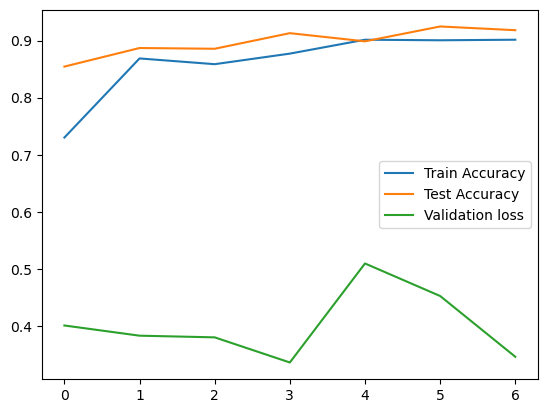

In [53]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [55]:
model.save("Corn_Disease.h5")